# Baseline Modeling using Shallow Learning 

This notebook contains the code and resourcers for training a baseline model for persuasive language detection. This notebook uses shallow (non deep learning) methods which can be configured in numerous ways to try and find the best approach. 

## Setting the Config
This is a file that can be used to set up the setup and variables for classifying the persuasion strategies 

- `df_path`: Path to the root data csv with the training data

- `aug_amount`: Either integer or Float depending on task. Integer is the amount of augmented samples and float is the percentage of the minority class that is added as augmented data
- `label`: Persuasion strategy for binary task
- `classification_type`: binary/multiclass/multilabel
- `model_type`: 1: Logistic Regression, 2: SVC, 3: MLP, 4: XGBoost 5: Random Forest 6: Decision Tree
- `confidence_threshold`: Threshold for accepting tag
- `verbose`: Additional printing
- `vectorizer_type`: TF-IDF or Count
- `ngram_range`: Ngram range (1,1), (1,2) etc.
- `apply_smote`: Apply SMOTE augmentation
- `scaler`: standard/minmax scaling 
- `label_method`: confidence/max - Use the confidence threshold or argmax
- `add_augmented`: Path to augmented data, leave blank if not using augmented data

In [17]:
config = {
    'data_path': '/Users/rt853/UoB-persuasion-detection/data/processed/root_plus_conf_vals.csv',
    'aug_amount': 0.2,
    'label': '2-NEGOTIATE',  # 1-RAPPORT 2-NEGOTIATE 3-EMOTION 4-LOGIC 5-AUTHORITY, 6-SOCIAL, 7-PRESSURE,
    'classification_type': 'binary',  # binary
    'model_type': 4,  # 1: Logistic Regression, 2: SVC, 3: MLP, 4: XGBoost 5: Random Forest 6: Decision Tree
    'confidence_threshold': 0.4,
    'verbose': True,  # True, False
    'vectorizer_type': 'tfidf',  # tfidf, count
    'ngram_range': '(1,1)',  # (1,1), (1,2), (2,2)
    'model_output_path': None,
    'result_output_path': None,
    'apply_smote': None,
    'scaler': True,
    'label_method': 'confidence',
    'add_augmented': None, #'/Users/rt853/UoB-persuasion-detection/data/training_sets/augmented/augmented_df_1-RAPPORT.csv',
    'augmented': None,
}

## Preprocess the data depending on task. 

Depending on what task we want to perform we can preprocess the data in various ways. For example:
- Binary:
    - The labels will be either 0/1 and the data will be split into positive/negative cases depending on the label
    - A confidence threshold can also be chosen to choose how many data points are given a positive class 
- Multiclass:
    - Labels will be give a number from 0-8
- Multilabel: 
    - Labels will be in the form of multi-hot vectors 

In [18]:
import sys 
sys.path.append('/Users/rt853/UoB-HICCS-2025/src')

from baseline_model.main import data_pipeline
from baseline_model.model import train_model
from baseline_model.evaluate import evaluate_model

import pandas as pd 

from tqdm.auto import tqdm

In [29]:
df = pd.read_csv(config['data_path'])
df = df.dropna()
df

,text,label,persuader,dataset_name,dataset_subdir,user,annotation_id,line_id,transcript_id,file_path,...,gold_full,gold,1-RAPPORT,2-NEGOTIATE,3-EMOTION,4-LOGIC,5-AUTHORITY,6-SOCIAL,7-PRESSURE,8-NO-PERSUASION
0,persuader: hello,8-NO-PERSUASION,True,persuasion_4_good,batch_1,Pablo,98bc3a541bba599c36f2d3dd7a0c38df,7c84580e773798963a11b94c517c3926,894860aabd26d39364ccde8663605502,/Users/rt853/UoB-persuasion-detection/data/roo...,...,8-NO-PERSUASION,8-NO-PERSUASION,0.1667,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.8333
1,persuader: ok i just donated to save the child...,6-SOCIAL-OTHER,True,persuasion_4_good,batch_1,Pablo,bcaf39f740037640a3a01632e50f5ae7,3c43e8cfba7864f665ae53973ac87c1a,894860aabd26d39364ccde8663605502,/Users/rt853/UoB-persuasion-detection/data/roo...,...,2-NEGOTIATE-REQUEST,2-NEGOTIATE,0.2692,0.3462,0.2692,0.0,0.0,0.1154,0.0,0.0000
2,persuader: for give my typos crippled hands. i...,6-SOCIAL-OTHER,True,persuasion_4_good,batch_1,Pablo,aed46a84ce7449d10ac9158373906541,ba09b48d495f497d9a1bd4b90e7320c2,894860aabd26d39364ccde8663605502,/Users/rt853/UoB-persuasion-detection/data/roo...,...,1-RAPPORT-DISCLOSE,1-RAPPORT,0.6923,0.1538,0.0000,0.0,0.0,0.0769,0.0,0.0769
4,persuader: so how much do you say you want to ...,7-PRESSURE-PRESIST,True,persuasion_4_good,batch_1,Pablo,f08ac42633ed95b5cbad3154a5797cfc,74796c1b10c1a8df83ec626815623d98,894860aabd26d39364ccde8663605502,/Users/rt853/UoB-persuasion-detection/data/roo...,...,7-PRESSURE-PRESIST,7-PRESSURE,0.0000,0.5000,0.0000,0.0,0.0,0.0000,0.5,0.0000
6,persuader: ok like you i gave .20 cents to the...,1-RAPPORT-DISCLOSE,True,persuasion_4_good,batch_1,Pablo,1bdc142c9814d48885a558708d6ce83b,3b61ceff96e1411e582f6660ee3d11ec,894860aabd26d39364ccde8663605502,/Users/rt853/UoB-persuasion-detection/data/roo...,...,1-RAPPORT-DISCLOSE,1-RAPPORT,0.7500,0.0000,0.0000,0.0,0.0,0.1250,0.0,0.1250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15162,persuader: i’m a supportive husband,1-RAPPORT-FRIEND,True,romance_scam,romance_scam_1_b,Adela,46adbee7234e4ff51adcbc1e02d86e89,23b6c34bfb2657f7b0f86ce1be33645b,0026eff05638f98f53083c8716715036,/Users/rt853/UoB-persuasion-detection/data/roo...,...,1-RAPPORT-FRIEND,1-RAPPORT,1.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000
15183,persuader: you can put your head on my chest i...,1-RAPPORT-FRIEND,True,romance_scam,romance_scam_1_b,Adela,9f63c0fdbe889d1abd7a445a39f09723,b392c9b01d9aa4aa67f1851122dd736a,06fa123e79325d1c6e9b81dd87f48881,/Users/rt853/UoB-persuasion-detection/data/roo...,...,1-RAPPORT-FRIEND,1-RAPPORT,1.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000
15210,persuader: i don't know why she did not contac...,1-RAPPORT-DISCLOSE,True,romance_scam,romance_scam_1_b,Adela,f7275fdd90a900c0195c85e2a970700c,5559a1156c39c660f2b553fe4af114ab,807e54dc34fabac297abb2d820e899ad,/Users/rt853/UoB-persuasion-detection/data/roo...,...,1-RAPPORT-DISCLOSE,1-RAPPORT,1.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000
15218,persuader: good night,1-RAPPORT-FRIEND,True,romance_scam,romance_scam_1_b,Adela,306417f6c63e256706041bf220ebd839,4a3625e94309c02a75feb75a192aac06,34ea66ef5a37891bcf3f28558a3f26e6,/Users/rt853/UoB-persuasion-detection/data/roo...,...,1-RAPPORT-FRIEND,1-RAPPORT,1.0000,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.0000


In [ ]:

keep_cols = ['text', 'label', '1-RAPPORT', '2-NEGOTIATE', '3-EMOTION', '4-LOGIC', '5-AUTHORITY', '8-NO-PERSUASION']
for c_name in ['1-RAPPORT', '2-NEGOTIATE', '3-EMOTION', '4-LOGIC', '5-AUTHORITY', '8-NO-PERSUASION']:
    binary_df = df.copy()[keep_cols]
    pos_df = binary_df[binary_df[c_name] == 1]
    pos_df['binary'] = 1
    neg_df = binary_df[binary_df[c_name] == 0]
    neg_df['binary'] = 0
    ddf = pd.concat([pos_df, neg_df]).reset_index(drop=True)
    break

/var/folders/n6/bphk0l151ld6d28btfsr_62r0000gp/T/ipykernel_13247/1218697586.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pos_df['binary'] = 1
/var/folders/n6/bphk0l151ld6d28btfsr_62r0000gp/T/ipykernel_13247/1218697586.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  neg_df['binary'] = 0


In [27]:
ddf.binary.value_counts()

binary
0    1798
1    1723
Name: count, dtype: int64

## Train the Model 

Depending on the model type chosen in the config we can train various models.

1. Logistic Regression
2. SVC
3. MLP
4. XGBoost 
5. Random Forest
6. Decision Tree

The models may also be wrapped ina one vs rest wrapper for multilable/multiclass classification

In [57]:
for label in tqdm(datasets):
    train_x = datasets[label]['train_x']
    train_y = datasets[label]['train_y']
    datasets[label]['model'] = train_model(train_x, train_y, config)


  0%|          | 0/7 [00:00<?, ?it/s]

## Evaluation 

Once the model is trained we must evaluate it to monitor performance of the classifier on our task. 

In [58]:
from baseline_model.utils import init_labels

for label in datasets:
    model = datasets[label]['model']
    test_df = datasets[label]['test']
    vecrtorizer = datasets[label]['vectorizer']
    report = evaluate_model(model, config.get('classification_type'), vectorizer, test_df)
    print(report)

            negative  positive  accuracy  macro avg  weighted avg
precision     0.8621    0.4967  0.807288     0.6794        0.7921
recall        0.9066    0.3887  0.807288     0.6476        0.8073
f1-score      0.8838    0.4361  0.807288     0.6600        0.7980
support    2462.0000  584.0000  0.807288  3046.0000     3046.0000
            negative  positive  accuracy  macro avg  weighted avg
precision     0.9621    0.2951  0.948785     0.6286        0.9335
recall        0.9852    0.1374  0.948785     0.5613        0.9488
f1-score      0.9736    0.1875  0.948785     0.5805        0.9398
support    2915.0000  131.0000  0.948785  3046.0000     3046.0000
            negative  positive  accuracy  macro avg  weighted avg
precision     0.9697    0.1522  0.957321     0.5609        0.9434
recall        0.9868    0.0714  0.957321     0.5291        0.9573
f1-score      0.9781    0.0972  0.957321     0.5377        0.9498
support    2948.0000   98.0000  0.957321  3046.0000     3046.0000
          

## Data Visualisation 

A confusion matrix is a table used to evaluate the performance of a classification model. It compares the actual target values with the predicted values from the model. The matrix is organized as follows:

- **True Positives (TP):** Correctly predicted positive cases.
- **True Negatives (TN):** Correctly predicted negative cases.
- **False Positives (FP):** Incorrectly predicted as positive (Type I error).
- **False Negatives (FN):** Incorrectly predicted as negative (Type II error).

The confusion matrix helps calculate various performance metrics such as accuracy, precision, recall, and F1-score, which provide insights into the model's effectiveness.

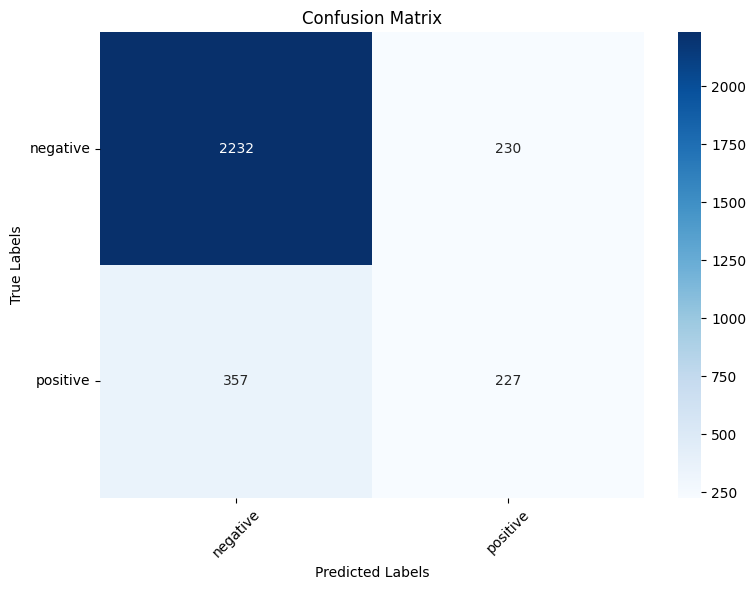

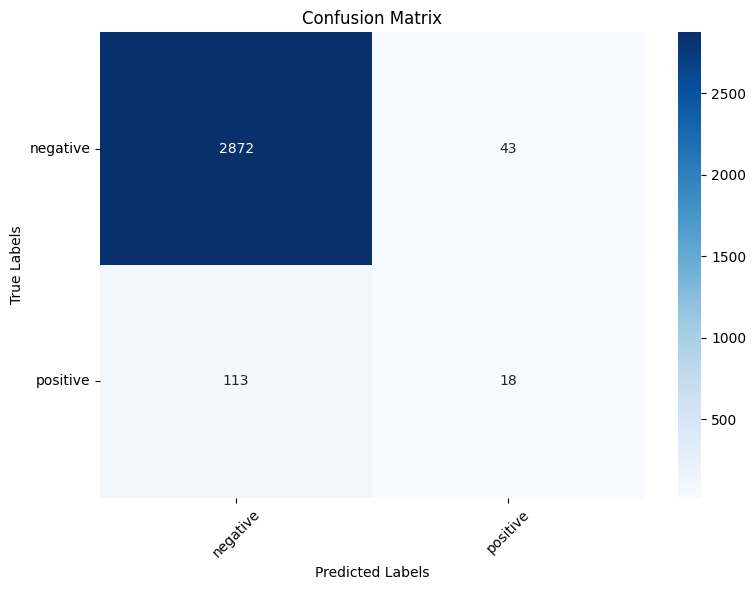

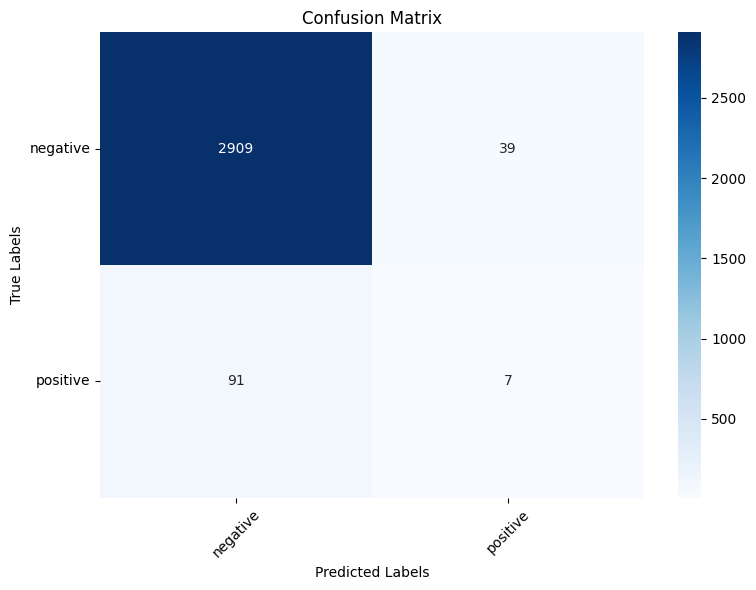

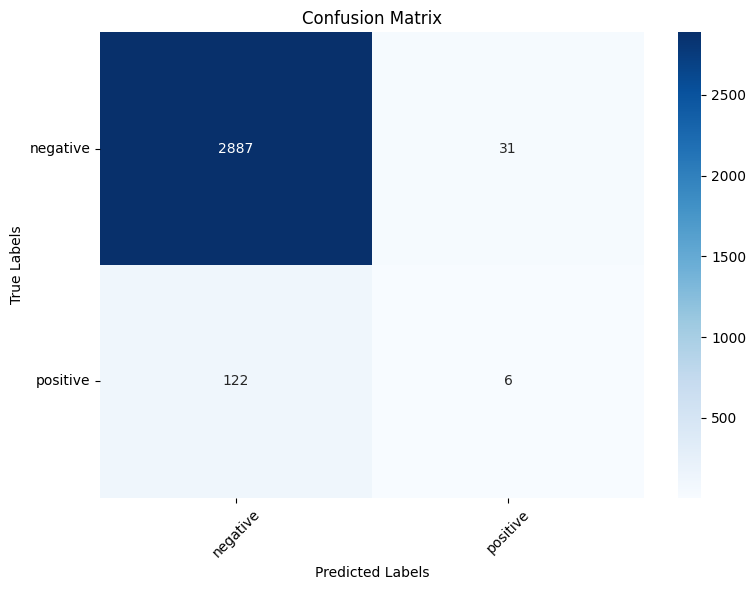

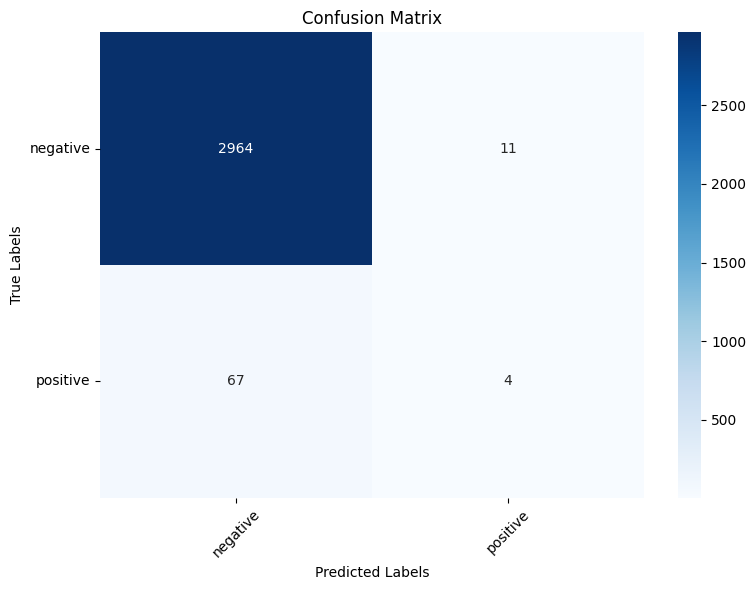

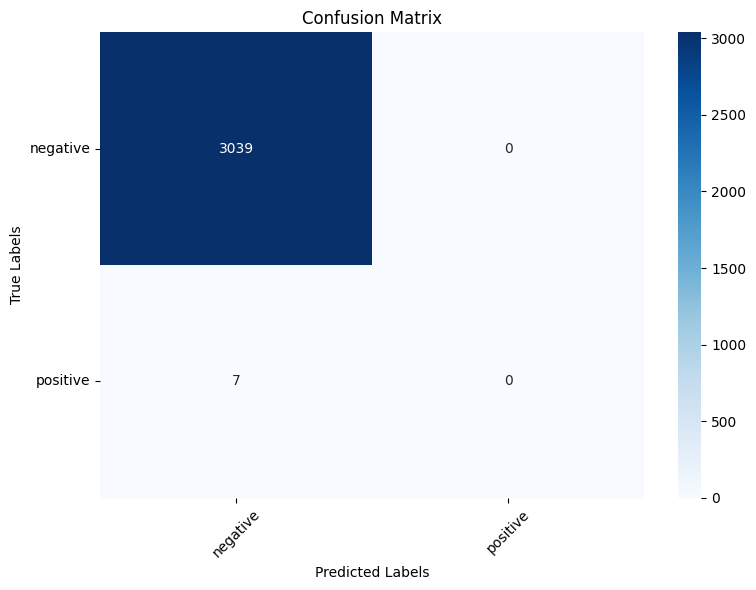

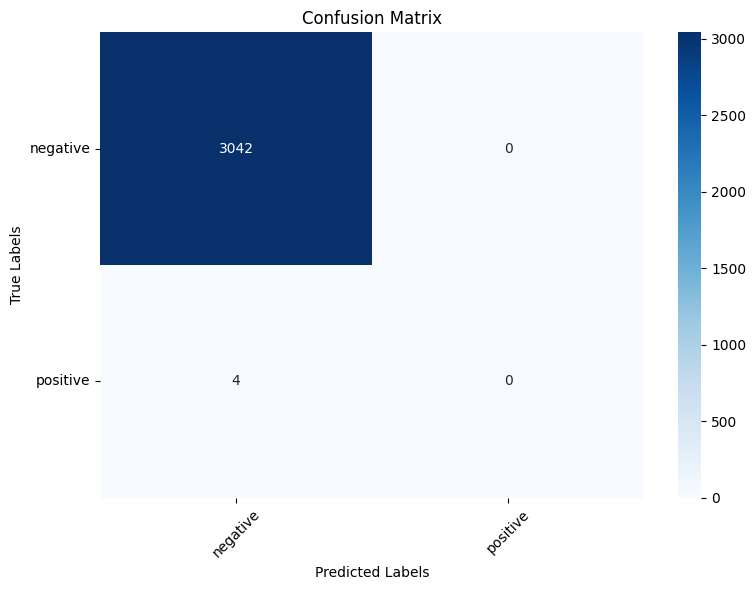

In [60]:
from baseline_model.evaluate import plot_confusion_matrix, plot_auprc_curve

for label in datasets:
    vectorizer = datasets[label]['vectorizer']
    model = datasets[label]['model']
    preds = model.predict(vectorizer.transform(test_df.text))
    test_df = datasets[label]['test']
    conf_mat = plot_confusion_matrix(
        test_df['binary'], 
            preds,
            config.get('classification_type')
    )

## Plotting Area under Precision/Recall Curve 

The Area Under the Precision-Recall Curve (AUPRC) is a performance metric used to evaluate the effectiveness of a classification model, particularly in imbalanced datasets. It measures the trade-off between precision (the proportion of true positive predictions among all positive predictions) and recall (the proportion of true positive predictions among all actual positives) across different thresholds. A higher AUPRC indicates better model performance, as it reflects a balance between precision and recall.

In [70]:
roc_curve(y_true == i, y_pred_proba[:, i])


IndexError: index 2 is out of bounds for axis 1 with size 2

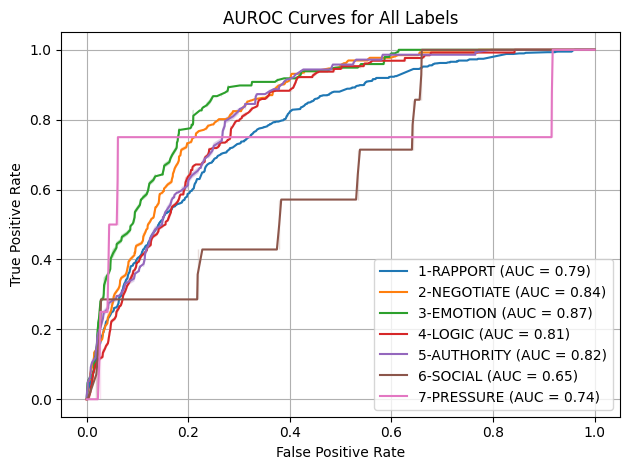

In [86]:

import seaborn as sns

labels = ['1-RAPPORT', '2-NEGOTIATE', '3-EMOTION', '4-LOGIC', '5-AUTHORITY', '6-SOCIAL', '7-PRESSURE']

num_labels = len(labels)

for idx, label in enumerate(datasets):
    model = datasets[label]['model']
    test_df = datasets[label]['test']
    vectorizer = datasets[label]['vectorizer']
    y_true = test_df['binary'].values
    y_scores = model.predict_proba(vectorizer.transform(test_df['text']))[:, 1]  # Get probabilities for the positive class

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    sns.lineplot(x=fpr, y=tpr, label=f'{label} (AUC = {roc_auc:.2f})')

plt.title('AUROC Curves for All Labels')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/rt853/UoB-HICCS-2025/data/figures/auroc_all_labels.png')
plt.show()


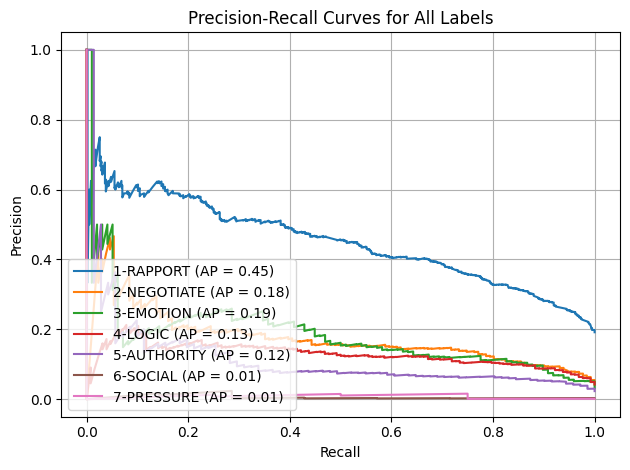

In [83]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

for idx, label in enumerate(datasets):
    model = datasets[label]['model']
    test_df = datasets[label]['test']
    vectorizer = datasets[label]['vectorizer']
    y_true = test_df['binary'].values
    y_scores = model.predict_proba(vectorizer.transform(test_df['text']))[:, 1]  # Get probabilities for the positive class

    precision, recall, _ = precision_recall_curve(y_true, y_scores)
    avg_precision = average_precision_score(y_true, y_scores)

    plt.plot(recall, precision, label=f'{label} (AP = {avg_precision:.2f})')

plt.title('Precision-Recall Curves for All Labels')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower left")
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/rt853/UoB-HICCS-2025/data/figures/precision_recall_curve.png')
plt.show()


## Outputting the Model 

To output the experiment 

In [40]:
from baseline_model.utils import gen_output_config, output_experiment

experiment_name = gen_output_config(config)
experiment_folder = '/Users/rt853/UoB-HICCS-2025/data/results/binary/'

output_experiment(
    experiment_folder, experiment_name, train_df,
        test_df, model, report, vectorizer, config,
            )

Outputting to:  /Users/rt853/UoB-HICCS-2025/data/results/binary/2-NEGOTIATE_class_type_binary_model_type_4_label_method_max_confidence_threshold_0.2_vect_type_tfidf_apply_smote_None_scaler_True_


'Done'

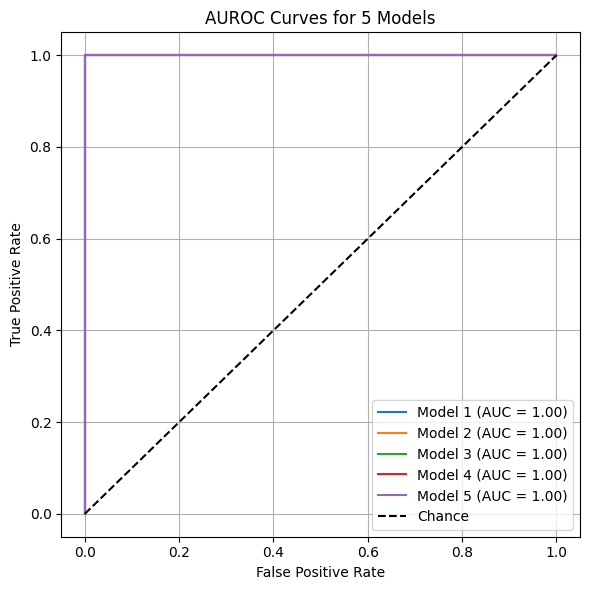

In [42]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import numpy as np

np.random.seed(42)
plt.figure(figsize=(6, 6))

for i in range(5):
    # Simulate ground truth
    y_true = np.random.randint(0, 2, 100)

    # Generate "smart" predicted scores
    y_scores = (
        y_true * np.random.uniform(0.6, 1.0, size=100) +  # positives closer to 1
        (1 - y_true) * np.random.uniform(0.0, 0.4, size=100)  # negatives closer to 0
    )

    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'Model {i+1} (AUC = {roc_auc:.2f})')

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--', label='Chance')

# Plot formatting
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curves for 5 Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig('dummy_auroc_curved.png', dpi=300)
plt.show()
